In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from helpers import *
from dataset import *
#4*4の行列を作成

a = np.array([[1,2,3,4],[5,6,7,8],[9,10,11,12],[13,14,15,16]])

In [17]:
def rotate_3d_volume_x_axis(
    volume: np.ndarray,
    anglex: float,
    angley: float,
    anglez: float
) -> np.ndarray:
    """
    3次元配列 (184, 184, 630) を受け取り:
      1) まず (1000, 1000, 1000) の大きな配列に中心配置する
      2) x軸回りに anglex度, y軸回りに angley度, z軸回りに anglez度 の順に回転する
      3) 回転後の (1000, 1000, 1000) の配列を返す

    ※ OpenCV(cv2) の2Dアフィン変換をスライス毎に適用した簡易的な方法です。
       計算コストが非常に大きい点に注意してください。

    Parameters
    ----------
    volume : np.ndarray, shape==(184,184,630)
        回転させたい3次元ボリューム (1チャネル想定)
    anglex : float
        x軸回りの回転角度（度数法）
    angley : float
        y軸回りの回転角度（度数法）
    anglez : float
        z軸回りの回転角度（度数法）

    Returns
    -------
    big_volume : np.ndarray, shape==(1000,1000,1000)
        3軸回転後の大きな3次元配列
    """
    # --- 1) 入力 shape をチェック ---
    X, Y, Z = volume.shape
    if (X, Y, Z) != (184, 630, 630):
        raise ValueError(f"入力のshapeが (184, 630, 630) ではありません: {volume.shape}")

    # --- 2) (1000, 1000, 1000) のボリュームを用意 (ゼロ埋め) ---
    big_volume = np.zeros((1000, 1000, 1000), dtype=volume.dtype)

    # 元ボリュームの中心 (x_center, y_center, z_center)
    x_center_in = X // 2  # = 92
    y_center_in = Y // 2  # = 92
    z_center_in = Z // 2  # = 315

    # 大きいボリュームの中心 (500, 500, 500) に合わせるためのオフセット
    # x,y,zそれぞれ (500 - 中心)
    x_offset = 500 - x_center_in  # 500 - 92 = 408
    y_offset = 500 - y_center_in  # 500 - 92 = 408
    z_offset = 500 - z_center_in  # 500 - 315=185

    # --- 3) (184,184,630) を (1000,1000,1000) の中央へコピー ---
    #     big_volume[x+408, y+408, z+185] = volume[x,y,z]
    for x in range(X):
        for y in range(Y):
            for z in range(Z):
                bx = x + x_offset
                by = y + y_offset
                bz = z + z_offset
                big_volume[bx, by, bz] = volume[x, y, z]

    # 3つの回転をまとめて行う。順番は (x) → (y) → (z) の順
    # ------------------------------------------------------------------
    # ★ 非常に大きな計算負荷 ★
    # 以下の3ステップそれぞれで 1000スライス × 1000x1000 画素のwarpAffineを行います。

    # -------- A) x軸回りに anglex 度 回転 --------
    if abs(anglex) > 1e-7:
        center_2d = (500, 500)  # 2D回転の中心座標
        Mx = cv2.getRotationMatrix2D(center_2d, anglex, 1.0)
        for x in range(1000):
            # big_volume[x,:,:] は形状 (1000,1000) => (row, col)=(y,z)
            slice_2d = big_volume[x, :, :]
            rotated_2d = cv2.warpAffine(
                slice_2d,
                Mx,
                (1000, 1000),
                flags=cv2.INTER_LINEAR,
                borderMode=cv2.BORDER_CONSTANT,
                borderValue=0
            )
            big_volume[x, :, :] = rotated_2d

    # -------- B) y軸回りに angley 度 回転 --------
    if abs(angley) > 1e-7:
        center_2d = (500, 500)
        My = cv2.getRotationMatrix2D(center_2d, angley, 1.0)
        for y in range(1000):
            # big_volume[:,y,:] は形状 (1000,1000)
            #   row → x方向 (0~999), col → z方向 (0~999)
            slice_2d = big_volume[:, y, :].copy()  # メモリ連続でないのでcopy()推奨
            rotated_2d = cv2.warpAffine(
                slice_2d,
                My,
                (1000, 1000),
                flags=cv2.INTER_LINEAR,
                borderMode=cv2.BORDER_CONSTANT,
                borderValue=0
            )
            # 回転後を再び big_volume[:, y, :] に書き戻す
            big_volume[:, y, :] = rotated_2d

    # -------- C) z軸回りに anglez 度 回転 --------
    if abs(anglez) > 1e-7:
        center_2d = (500, 500)
        Mz = cv2.getRotationMatrix2D(center_2d, anglez, 1.0)
        for z in range(1000):
            # big_volume[:,:,z] は形状 (1000,1000)
            #   row → x方向, col → y方向
            slice_2d = big_volume[:, :, z].copy()
            rotated_2d = cv2.warpAffine(
                slice_2d,
                Mz,
                (1000, 1000),
                flags=cv2.INTER_LINEAR,
                borderMode=cv2.BORDER_CONSTANT,
                borderValue=0
            )
            big_volume[:, :, z] = rotated_2d

    return big_volume

def rotate_3d_mask_x_axis(
    volume: np.ndarray,
    anglex: float,
    angley: float,
    anglez: float
) -> np.ndarray:
    """
    3次元配列 (184, 184, 630) を受け取り:
      1) まず (1000, 1000, 1000) の大きな配列に中心配置する
      2) x軸回りに anglex度, y軸回りに angley度, z軸回りに anglez度 の順に回転する
      3) 回転後の (1000, 1000, 1000) の配列を返す

    ※ OpenCV(cv2) の2Dアフィン変換をスライス毎に適用した簡易的な方法です。
       計算コストが非常に大きい点に注意してください。

    Parameters
    ----------
    volume : np.ndarray, shape==(184,184,630)
        回転させたい3次元ボリューム (1チャネル想定)
    anglex : float
        x軸回りの回転角度（度数法）
    angley : float
        y軸回りの回転角度（度数法）
    anglez : float
        z軸回りの回転角度（度数法）

    Returns
    -------
    big_volume : np.ndarray, shape==(1000,1000,1000)
        3軸回転後の大きな3次元配列
    """
    # --- 1) 入力 shape をチェック ---
    X, Y, Z = volume.shape
    if (X, Y, Z) != (184, 630, 630):
        raise ValueError(f"入力のshapeが (184, 630, 630) ではありません: {volume.shape}")

    # --- 2) (1000, 1000, 1000) のボリュームを用意 (ゼロ埋め) ---
    big_volume = np.zeros((1000, 1000, 1000), dtype=volume.dtype)

    # 元ボリュームの中心 (x_center, y_center, z_center)
    x_center_in = X // 2  # = 92
    y_center_in = Y // 2  # = 92
    z_center_in = Z // 2  # = 315

    # 大きいボリュームの中心 (500, 500, 500) に合わせるためのオフセット
    # x,y,zそれぞれ (500 - 中心)
    x_offset = 500 - x_center_in  # 500 - 92 = 408
    y_offset = 500 - y_center_in  # 500 - 92 = 408
    z_offset = 500 - z_center_in  # 500 - 315=185

    # --- 3) (184,184,630) を (1000,1000,1000) の中央へコピー ---
    #     big_volume[x+408, y+408, z+185] = volume[x,y,z]
    for x in range(X):
        for y in range(Y):
            for z in range(Z):
                bx = x + x_offset
                by = y + y_offset
                bz = z + z_offset
                big_volume[bx, by, bz] = volume[x, y, z]

    # 3つの回転をまとめて行う。順番は (x) → (y) → (z) の順
    # ------------------------------------------------------------------
    # ★ 非常に大きな計算負荷 ★
    # 以下の3ステップそれぞれで 1000スライス × 1000x1000 画素のwarpAffineを行います。

    # -------- A) x軸回りに anglex 度 回転 --------
    if abs(anglex) > 1e-7:
        center_2d = (500, 500)  # 2D回転の中心座標
        Mx = cv2.getRotationMatrix2D(center_2d, anglex, 1.0)
        for x in range(1000):
            # big_volume[x,:,:] は形状 (1000,1000) => (row, col)=(y,z)
            slice_2d = big_volume[x, :, :]
            rotated_2d = cv2.warpAffine(
                slice_2d,
                Mx,
                (1000, 1000),
                flags=cv2.INTER_NEAREST,
                borderMode=cv2.BORDER_CONSTANT,
                borderValue=0
            )
            big_volume[x, :, :] = rotated_2d

    # -------- B) y軸回りに angley 度 回転 --------
    if abs(angley) > 1e-7:
        center_2d = (500, 500)
        My = cv2.getRotationMatrix2D(center_2d, angley, 1.0)
        for y in range(1000):
            # big_volume[:,y,:] は形状 (1000,1000)
            #   row → x方向 (0~999), col → z方向 (0~999)
            slice_2d = big_volume[:, y, :].copy()  # メモリ連続でないのでcopy()推奨
            rotated_2d = cv2.warpAffine(
                slice_2d,
                My,
                (1000, 1000),
                flags=cv2.INTER_NEAREST,
                borderMode=cv2.BORDER_CONSTANT,
                borderValue=0
            )
            # 回転後を再び big_volume[:, y, :] に書き戻す
            big_volume[:, y, :] = rotated_2d

    # -------- C) z軸回りに anglez 度 回転 --------
    if abs(anglez) > 1e-7:
        center_2d = (500, 500)
        Mz = cv2.getRotationMatrix2D(center_2d, anglez, 1.0)
        for z in range(1000):
            # big_volume[:,:,z] は形状 (1000,1000)
            #   row → x方向, col → y方向
            slice_2d = big_volume[:, :, z].copy()
            rotated_2d = cv2.warpAffine(
                slice_2d,
                Mz,
                (1000, 1000),
                flags=cv2.INTER_NEAREST,
                borderMode=cv2.BORDER_CONSTANT,
                borderValue=0
            )
            big_volume[:, :, z] = rotated_2d

    return big_volume



In [20]:
train_dir = '../input/czii-cryo-et-object-identification/train/static/ExperimentRuns/'
mask_dir = '../input/czii-cryo-et-object-identification/train/overlay/ExperimentRuns/'

valid_id = ['TS_99_9', "TS_6_4", "TS_6_6", "TS_69_2", "TS_73_6", "TS_86_3"]
test_id = ["TS_5_4"]


data = read_one_data(valid_id[1], train_dir)
y = read_one_truth(valid_id[1], mask_dir)
mask_data = generate_mask(y, mask_size)

data = data.astype(np.float32)
mask_data = mask_data.astype(np.uint8)

anglex, angley, anglez = 5, 5, 5

big_vol = rotate_3d_volume_x_axis(data, anglex, angley, anglez)
big_mask = rotate_3d_mask_x_axis(mask_data, anglex, angley, anglez)

print(big_vol.shape, big_mask.shape)

(1000, 1000, 1000) (1000, 1000, 1000)


(184, 630, 630) (184, 630, 630)


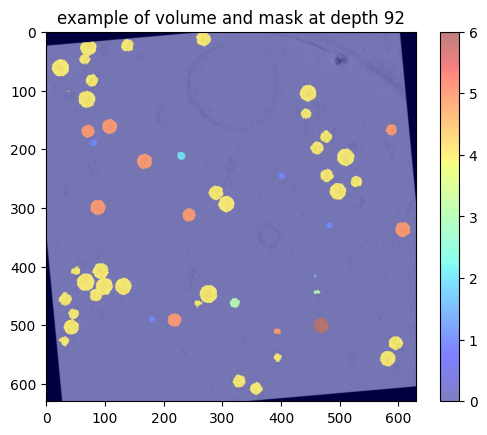

In [21]:
vol_slice = big_vol[408:592, 185:815, 185:815]
mask_slice = big_mask[408:592, 185:815, 185:815]

print(vol_slice.shape, mask_slice.shape)
print_slices(vol_slice, mask_slice,3,1,92)